In [146]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import re
import joblib
from datetime import datetime
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, get_scorer_names
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM
from xgboost import XGBRegressor
from copy import deepcopy
warnings.filterwarnings("ignore")

In [97]:
df = pd.read_csv("../data/merge_all/merge_all.csv", index_col=0)
# df.info()

In [98]:
# 인덱스를 datetime으로 변경
df.index = pd.to_datetime(df.index,format="%Y-%m-%d")
# df.index
# df.info()

In [99]:
# rolling 메소드를 이용한 이동평균 만들기
mov_list = [5, 7, 28]
for mov in mov_list :
    globals()["df_mov_avr"+str(mov)] = df["평균"].rolling(mov, min_periods=1).mean()

In [100]:
df_yester = df["평균"].shift(1)      # 전날 가격을 추출
df_yester[0] = (6040+5160)/2        # 1999년 12월 31일 배추 평균값
# df_yester

In [101]:
df = pd.concat([df, df_yester , df_mov_avr5, df_mov_avr7, df_mov_avr28],axis=1)
# df

In [102]:
df.columns = ["자동차용 경유 가격 (원)", "전월비(%)", "평균 가격(원)", "거래량 (kg)", "전일 평균가격" , "이동 평균가격_5일", "이동 평균가격_7일","이동 평균가격_28일"]
# df.info()

In [103]:
feature = df[["자동차용 경유 가격 (원)", "전월비(%)", "거래량 (kg)", "전일 평균가격" , "이동 평균가격_5일", "이동 평균가격_7일","이동 평균가격_28일"]]
target = df["평균 가격(원)"]

In [104]:
std = StandardScaler()
std.fit(feature)
feature_std = std.transform(feature)

In [10]:
# feature_std

In [105]:
std2 = StandardScaler()
std2.fit(target.values.reshape(-1,1))
target_std = std2.transform(target.values.reshape(-1,1))
# target_std.shape

In [106]:
# 가격을 제외한 독립 변수 선택
feature_except_price = df[["자동차용 경유 가격 (원)", "전월비(%)", "거래량 (kg)"]]

In [107]:
std_except_price = StandardScaler()
std_except_price.fit(feature_except_price)
feature_std_except_price = std_except_price.transform(feature_except_price)

In [108]:
# 전날 가격 포함, 전월비 제외 독립변수
feature_yes_price = df[["자동차용 경유 가격 (원)", "거래량 (kg)", "전일 평균가격"]]

std_yes_price = StandardScaler()
std_yes_price.fit(feature_yes_price)
feature_std_yes_price = std_yes_price.transform(feature_yes_price)

In [109]:
# 전날 가격 포함, 전월비 제외 독립변수, minmaxscale
mms_yes_price = MinMaxScaler()
mms_yes_price.fit(feature_yes_price)
feature_mms_yes_price = mms_yes_price.transform(feature_yes_price)

mms_target = MinMaxScaler()
mms_target.fit(target.values.reshape(-1,1))
target_mms = mms_target.transform(target.values.reshape(-1,1))

In [110]:
# 이동평균 7일 포함, 전월비 제외 독립변수
feature_seven_price = df[["자동차용 경유 가격 (원)", "거래량 (kg)", "이동 평균가격_7일"]]

std_seven_price = StandardScaler()
std_seven_price.fit(feature_seven_price)
feature_std_seven_price = std_seven_price.transform(feature_seven_price)

In [111]:
# 이동평균 5일 포함, 전월비 제외 독립변수
feature_five_price = df[["자동차용 경유 가격 (원)", "거래량 (kg)", "이동 평균가격_5일"]]

std_five_price = StandardScaler()
std_five_price.fit(feature_five_price)
feature_std_five_price = std_five_price.transform(feature_five_price)

In [112]:
# 전일 가격, 이동평균 5일 포함, 전월비 제외 독립변수
feature_yes_fi_price = df[["자동차용 경유 가격 (원)", "거래량 (kg)", "전일 평균가격", "이동 평균가격_5일"]]

std_yes_fi_price = StandardScaler()
std_yes_fi_price.fit(feature_yes_fi_price)
feature_std_yes_fi_price = std_yes_fi_price.transform(feature_yes_fi_price)

In [151]:
# 전월비만 뺀 독립변수
feature_except_prop = df.drop(columns=["평균 가격(원)","전월비(%)"])

std_except_prop = StandardScaler()
std_except_prop.fit(feature_except_prop)
feature_std_except_prop = std_except_prop.transform(feature_except_prop)

## 12월 테스트용 데이터 프레임 만들기

In [162]:
df_price = pd.read_csv("../data/price/price_baechoo.csv")
# df_price.tail(10)

In [163]:
df_price.set_index("구분", inplace=True)   # 구분 column을 인덱스로 설정
# df_price

In [164]:
df_price["전일 평균가격"] = df_price.shift(1)    # 전 인덱스의 값을 shift
df_price["전일 평균가격"].tail(30)

구분
2022-11-08    7330.0
2022-11-09    7193.5
2022-11-10    6760.0
2022-11-11    6952.0
2022-11-14    6992.0
2022-11-15    6724.0
2022-11-16    6684.0
2022-11-17    6900.0
2022-11-18    6432.0
2022-11-21    7018.0
2022-11-22    6300.0
2022-11-23    6260.0
2022-11-24    6100.0
2022-11-25    6100.0
2022-11-28    6100.0
2022-11-29    5664.0
2022-11-30    5592.0
2022-12-01    5242.0
2022-12-05    5462.0
2022-12-06    5982.0
2022-12-07    5502.0
2022-12-08    5488.0
2022-12-09    5408.0
2022-12-12    5408.0
2022-12-13    5244.5
2022-12-14    5245.5
2022-12-15    5430.5
2022-12-16    5430.5
2022-12-19    5304.0
2022-12-20    5459.5
Name: 전일 평균가격, dtype: float64

In [165]:
df_price["전일 평균가격"].head()

구분
2000-01-03       NaN
2000-01-04    5600.0
2000-01-05    5600.0
2000-01-06    5620.0
2000-01-07    5700.0
Name: 전일 평균가격, dtype: float64

In [117]:
for mov in mov_list :
    df_price["이동 평균가격_"+str(mov)+"일"] = df_price["평균"].rolling(mov, min_periods=1).mean()

In [118]:
df_price = df_price.tail(13)
# df_price.head()

In [119]:
df_price.index = pd.to_datetime(df_price.index)

In [24]:
local_path = "C:/workspace/datas/"

In [120]:
df_oil = pd.read_csv(local_path+"2022년_12월_주유소_경유가격.csv", encoding="cp949")
# df_oil.info()

In [26]:
# df_oil.head()

In [121]:
df_oil["구분"] = df_oil["구분"].apply(lambda x : datetime.strptime(str(x), "%Y년%m월%d일"))
# df_oil["구분"] = df_oil["구분"].apply(lambda x : datetime.strftime(x, "%Y년%m월%d일"))

In [122]:
df_oil.set_index("구분", inplace=True)
# df_oil.head()

In [123]:
df_supply = pd.read_csv("../data/transaction_supply/transaction_supply_baechoo.csv")
# df_supply.tail()

In [124]:
df_supply["거래년월일"] = pd.to_datetime(df_supply["거래년월일"])

In [125]:
df_supply.set_index("거래년월일", inplace=True)
# df_supply.head()

In [126]:
df_supply = df_supply[df_supply.index >= "2022-12-01"]

In [127]:
df_test = df_oil.join(df_price, how="outer")
df_test = df_test.join(df_supply, how="outer")
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22 entries, 2022-12-01 to 2022-12-22
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   자동차용경유       22 non-null     float64
 1   평균           13 non-null     float64
 2   전일 평균가격      13 non-null     float64
 3   이동 평균가격_5일   13 non-null     float64
 4   이동 평균가격_7일   13 non-null     float64
 5   이동 평균가격_28일  13 non-null     float64
 6   거래량          17 non-null     float64
dtypes: float64(7)
memory usage: 1.4 KB


In [128]:
df_test.fillna(df_test.ffill(), inplace=True)
# df_test

In [129]:
df_test_feat_yes = df_test[["자동차용경유", "거래량", "전일 평균가격"]]
df_test_tar = df_test["평균"]

In [130]:
df_test_feat_five = df_test[["자동차용경유", "거래량", "이동 평균가격_5일"]]

In [131]:
df_test_feat_seven = df_test[["자동차용경유", "거래량", "이동 평균가격_7일"]]

In [132]:
df_test_feat_yes_fi = df_test[["자동차용경유", "거래량", "전일 평균가격", "이동 평균가격_5일"]]

In [148]:
df_test_feat_except_prop = df_test[["자동차용경유", "거래량", "전일 평균가격" , "이동 평균가격_5일", "이동 평균가격_7일", "이동 평균가격_28일"]]

## LSTM

In [24]:
# # 딥러닝용 tensor로 변환
# X_train, X_test = feature_std[:6696].reshape(-1,3,1.), feature_std[6696:].reshape(-1,3,1)
# y_train, y_test = target_std[:6696], target_std[6696:]

In [25]:
# model = Sequential()
# model.add(LSTM(units=3, input_shape=(X_train.shape[1],1), activation="tanh", ))
# model.add(Dense(1))
# model.compile(loss="mean_squared_error",optimizer = "adam", metrics=["mse"])

In [102]:
# model.fit(X_train, y_train ,epochs=300, verbose=2)

In [103]:
# model.evaluate(X_test, y_test)

In [105]:
# y_pred = model.predict(X_test)
# print("r2 score :", r2_score(y_test, y_pred))

In [106]:
# y_pred_in = std2.inverse_transform(y_pred)

In [107]:
# fig = plt.figure((15,9))
# plt.plot(df)

## GridSearchCV

In [15]:
kfold = KFold(n_splits=10, shuffle=True, random_state=22)

iteration은 1 epoch를 시행할 때 필요한 미니배치 갯수를 의미합니다. 다른 말로는 1epoch을 마치는데 필요한 파라미터 업데이트 횟수

만약 10,000개의 데이터셋을 학습시킨다고 치자. (여기서 학습은 순방향 역방향 둘 다 포함)

메모리 한계 및 성능을 고려하여 나눠서 학습을 시킬 겁니다. 

이 때, 한 턴에 1,000개씩 10번 , 5턴을 학습시킨다고 하면, batch_size = 1,000 / iteration = 10 /epoch = 5입니다.

In [20]:
alpha = np.logspace(-4,2,7)   # lasso, ridge 해당
learning_rate = np.logspace(-4,2,7)   # adaboost, gradientboost 해당
eta = np.logspace(-4,2,7)   # xgboost 해당
max_iter = [1,3,5,10,20,50,100,150,200]   # lasso, ridge 해당
solver = ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']   # ridge 해당, 계산에 사용할 알고리즘
n_estimators = [1,3,5,10,15,20]   # randomforesteregressor(사용할 tree의 개수), gradientboost, adaboost, xgboost 해당
max_depth = [2,3,5,7,10,12]  # randomforesteregressor(tree의 깊이), gradientboost, xgboost 해당
criterion_rf = ["squared_error", "absolute_error", "friedman_mse", "poisson"]  # randomforesteregressor 해당
criterion_gb = ["squared_error", "friedman_mse"]  # gradientboost 해당
loss_ada = ["linear", "square", "exponential"]    # adaboost 해당
loss_gb = ["squared_error", "absolute_error", "huber", "quantile"]  # gradientboost 해당


In [28]:
model_lasso = ["Lasso"]
model_ridge = ["Ridge"]
model_rf = ["RandomForestRegressor"]
model_ada = ["AdaBoostRegressor"] 
model_grad = ["GradientBoostingRegressor"]
model_xgb = ["XGBRegressor"]

params_lasso = {"alpha" : alpha, 
                "max_iter" : max_iter}

params_ridge = {"alpha" : alpha, 
                "max_iter" : max_iter, 
                "solver" : solver}

params_rf = {"n_estimators" : n_estimators, 
                "max_depth" : max_depth, 
                "criterion" : criterion_rf}

params_ada = {"learning_rate" : learning_rate, 
                "n_estimators" : n_estimators, 
                "loss" : loss_ada
                }

params_grad = {"learning_rate" : learning_rate, 
                "n_estimators" : n_estimators, 
                "max_depth" : max_depth,
                "criterion" : criterion_gb}

params_xgb = {"eta" : eta,
                "n_estimators" : n_estimators, 
                "max_depth" : max_depth, 
                }

In [68]:
# lasso gridsearchcv
lasso = Lasso()
grid_lasso = GridSearchCV(estimator=lasso, param_grid=params_lasso, cv=kfold, n_jobs=-1, scoring="neg_mean_squared_error")
grid_lasso.fit(feature_std, target_std)
print("Best Score :", grid_lasso.best_score_)
print("Best Parameters :", grid_lasso.best_params_)

Best Score : -0.009160113859789262
Best Parameters : {'alpha': 0.0001, 'max_iter': 200}


In [69]:
# ridge gridsearchcv
ridge = Ridge()
grid_ridge = GridSearchCV(estimator=ridge, param_grid=params_ridge, cv=kfold, n_jobs=-1, scoring="neg_mean_squared_error")
grid_ridge.fit(feature_std, target_std)
print("Best Score :", grid_ridge.best_score_)
print("Best Parameters :", grid_ridge.best_params_)


Best Score : -0.009156406654891324
Best Parameters : {'alpha': 0.001, 'max_iter': 150, 'solver': 'sag'}


In [26]:
# RandomForestRegressor gridsearchcv
rf = RandomForestRegressor()
grid_rf = GridSearchCV(estimator=rf, param_grid=params_rf, cv=kfold, n_jobs=-1, scoring="neg_mean_squared_error")
grid_rf.fit(feature_std, target_std)
print("Best Score :", grid_rf.best_score_)
print("Best Parameters :", grid_rf.best_params_)

Best Score : -0.009954545782738902
Best Parameters : {'criterion': 'absolute_error', 'max_depth': 7, 'n_estimators': 20}


In [29]:
# adaboost gridsearchcv
ada = AdaBoostRegressor()
grid_ada = GridSearchCV(estimator=ada, param_grid=params_ada, cv=kfold, n_jobs=-1, scoring="neg_mean_squared_error")
grid_ada.fit(feature_std, target_std)
print("Best Score :", grid_ada.best_score_)
print("Best Parameters :", grid_ada.best_params_)

Best Score : -0.01999911541714563
Best Parameters : {'learning_rate': 0.1, 'loss': 'linear', 'n_estimators': 15}


In [30]:
# gradientboost gridsearchcv
grad = GradientBoostingRegressor()
grid_grad = GridSearchCV(estimator=grad, param_grid=params_grad, cv=kfold, n_jobs=-1, scoring="neg_mean_squared_error")
grid_grad.fit(feature_std, target_std)
print("Best Score :", grid_grad.best_score_)
print("Best Parameters :", grid_grad.best_params_)

Best Score : -0.012345999189884355
Best Parameters : {'criterion': 'squared_error', 'learning_rate': 1.0, 'max_depth': 3, 'n_estimators': 15}


In [31]:
# xgboost gridsearchcv
xgb = XGBRegressor()
grid_xgb = GridSearchCV(estimator=xgb, param_grid=params_xgb, cv=kfold, n_jobs=-1, scoring="neg_mean_squared_error")
grid_xgb.fit(feature_std, target_std)
print("Best Score :", grid_xgb.best_score_)
print("Best Parameters :", grid_xgb.best_params_)

Best Score : -0.012359615657034334
Best Parameters : {'eta': 1.0, 'max_depth': 3, 'n_estimators': 20}


## GridSearchCV를 통한 lasso 모델로 학습

In [88]:
## lasso 모델로 테스트  (모든 데이터를 학습 모델로 사용 후, 특정 시기를 테스트로 사용)
feature_len = int(len(feature_std)*0.8)
target_len = int(len(target_std)*0.8)

X_train, y_train = feature_std, target_std
X_test, y_test = feature_std[feature_len:], target_std[target_len:]

lasso_test = Lasso(alpha = 0.0001, max_iter = 200)
lasso_test.fit(X_train, y_train)
y_pred = lasso_test.predict(X_test)
print("rmse :", np.sqrt(mean_squared_error(y_test, y_pred)))
print("r2 score :", r2_score(y_test, y_pred))

rmse : 0.15466626744137923
r2 score : 0.9863145443926337


In [89]:
y_pred_inverse = std2.inverse_transform(y_pred.reshape(-1,1)).flatten()

In [80]:
len(target.values)

8370

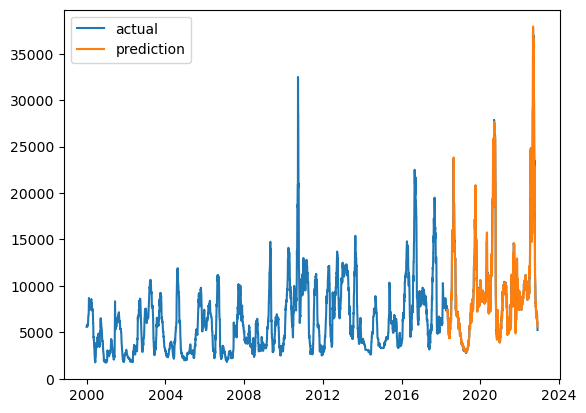

In [90]:
plt.plot(target.index.to_list(), target.values, label="actual")
plt.plot(target.index[target_len:], y_pred_inverse, label="prediction")
plt.legend()
plt.show()

In [30]:
# lasso cross_val_score  (불가)
X_train, X_test, y_train, y_test = train_test_split(feature_std, target_std, test_size=0.2, random_state=22)

# lasso_cross = Lasso(alpha = 0.0001, max_iter = 200)
# cross_val_lasso = cross_val_score(lasso_cross,X_train, y_train, cv=kfold)

In [34]:
# cross_val_lasso

In [23]:
# get_scorer_names()    # scoring의 이름들을 불러오는 메소드

In [33]:
# y_pred = lasso_cross.predict(X_test)
# print("r2_score : ",r2_score(y_test, y_pred))

In [134]:
# 가격을 뺀 독립변수를 이용한 lasso 모델 학습

X_train, X_test, y_train, y_test = train_test_split(feature_std_except_price, target_std, test_size=0.2, random_state=22)
lasso_test2 = Lasso(alpha = 0.0001, max_iter = 200)
lasso_test2.fit(X_train, y_train)
y_pred = lasso_test2.predict(X_test)
print("rmse :", np.sqrt(mean_squared_error(y_test, y_pred)))
print("r2 score :", r2_score(y_test, y_pred))

rmse : 0.8744962730522208
r2 score : 0.19396156394744613


In [160]:
# 전일 가격이 포함, 전월비 제외 독립변수를 이용한 lasso 모델 학습

X_train, X_test, y_train, y_test = train_test_split(feature_std_seven_price, target_std, test_size=0.2, random_state=22, shuffle=False)
lasso_test3 = Lasso(alpha = 0.0001, max_iter = 200)
lasso_test3.fit(X_train, y_train)
y_pred = lasso_test3.predict(X_test)
print("rmse :", np.sqrt(mean_squared_error(y_test, y_pred)))
print("r2 score :", r2_score(y_test, y_pred))

rmse : 0.2530523559569496
r2 score : 0.9633656221377692


In [86]:
# 전일 가격이 포함, 전월비 제외 독립변수를 이용한 lasso 모델 학습, minmaxscaling

X_train, X_test, y_train, y_test = train_test_split(feature_mms_yes_price, target_mms, test_size=0.2, random_state=22)
lasso_test4 = Lasso(alpha = 0.0001, max_iter = 200)
lasso_test4.fit(X_train, y_train)
y_pred = lasso_test4.predict(X_test)
print("rmse :", np.sqrt(mean_squared_error(y_test, y_pred)))
print("r2 score :", r2_score(y_test, y_pred))

rmse : 0.011421950991364664
r2 score : 0.9900012490274483


In [87]:
# 전일 가격, 5일 이동 평균으로 lasso 학습
X_train, X_test, y_train, y_test = train_test_split(feature_std_yes_fi_price, target_std, test_size=0.2, random_state=22, shuffle=False)
lasso_test5 = Lasso(alpha = 0.0001, max_iter = 200)
lasso_test5.fit(X_train, y_train)
y_pred = lasso_test5.predict(X_test)
print("rmse :", np.sqrt(mean_squared_error(y_test, y_pred)))
print("r2 score :", r2_score(y_test, y_pred))

rmse : 0.1571552522163225
r2 score : 0.9858705306886224


In [152]:
# 전월비만 뺀 변수로 lasso 학습
X_train, X_test, y_train, y_test = train_test_split(feature_std_except_prop, target_std, test_size=0.2, random_state=22, shuffle=False)
lasso_test6 = Lasso(alpha = 0.0001, max_iter = 200)
lasso_test6.fit(X_train, y_train)
y_pred = lasso_test6.predict(X_test)
print("rmse :", np.sqrt(mean_squared_error(y_test, y_pred)))
print("r2 score :", r2_score(y_test, y_pred))

rmse : 0.15204516698188744
r2 score : 0.9867744637451524


## GridSearchCV를 통한 xgboost 모델 학습

In [70]:
# xgboost를 이용한 가격 예측 모델
xgb_std = XGBRegressor(eta = 1, max_depth = 3, n_estimators = 20)

X_train, X_test, y_train, y_test = train_test_split(feature_std_yes_fi_price, target_std, test_size=0.2, random_state=22, shuffle=False)
xgb_std.fit(X_train, y_train)
y_pred = xgb_std.predict(X_test)
print("r2_score :",r2_score(y_test, y_pred))

r2_score : 0.9397499695711777


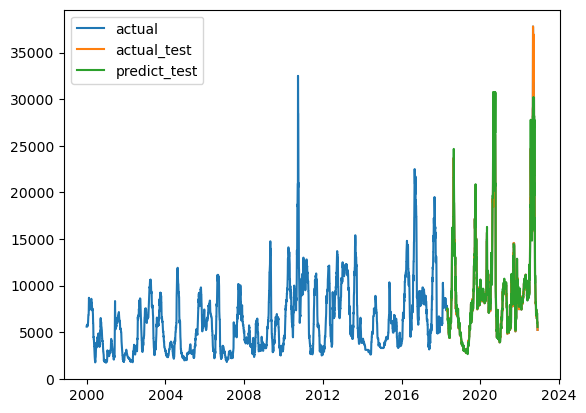

In [71]:
plt.plot(feature.index, target, label="actual")
plt.plot(feature.index[int(len(feature)*0.8):], std2.inverse_transform(y_test.reshape(-1,1)), label="actual_test")
plt.plot(feature.index[int(len(feature)*0.8):], std2.inverse_transform(y_pred.reshape(-1,1)), label="predict_test")
plt.legend()
plt.show()

## 12월 가격 예측 테스트 Lasso

In [161]:
X_test_12_std = std_seven_price.transform(df_test_feat)

y_pred_12_std = lasso_test3.predict(X_test_12_std)

print("r2_score :",r2_score(y_pred_12_std, std2.transform(df_test_tar.values.reshape(-1,1))))

r2_score : -0.9055362011133783


In [94]:
X_test_12_mms = mms_yes_price.transform(df_test_feat)

y_pred_12_mms = lasso_test4.predict(X_test_12_mms)

print("r2_score :",r2_score(y_pred_12_mms, mms_target.transform(df_test_tar.values.reshape(-1,1))))

r2_score : -1.0381613870377304


In [162]:
rev_normal_std = std2.inverse_transform(y_pred_12_std.reshape(-1,1))

In [99]:
rev_normal_mms = mms_target.inverse_transform(y_pred_12_mms.reshape(-1,1))

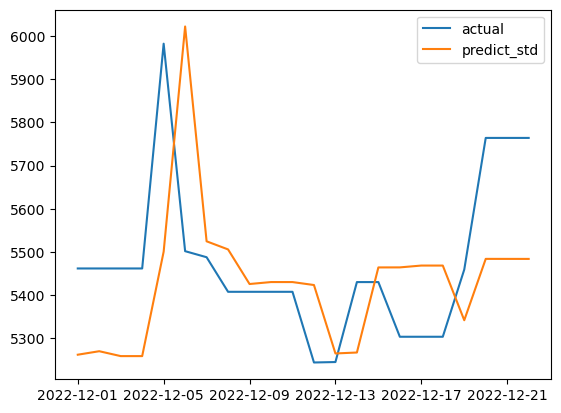

In [163]:
plt.plot(df_test_feat.index, df_test_tar, label="actual")
plt.plot(df_test_feat.index, rev_normal_std, label="predict_std")
# plt.plot(df_test_feat.index, rev_normal_mms, label="predict_mms")
plt.legend()
plt.show()

In [88]:
X_test_12_std = std_yes_fi_price.transform(df_test_feat_yes_fi)
y_pred_12_std = lasso_test5.predict(X_test_12_std)
rev_normal_std = std2.inverse_transform(y_pred_12_std.reshape(-1,1))
print("r2_score :",r2_score(rev_normal_std, df_test_tar.values.reshape(-1,1)))

r2_score : -1.0568878097558412


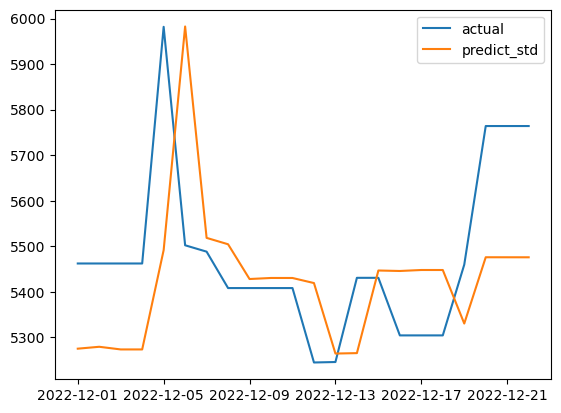

In [89]:
plt.plot(df_test_feat_yes.index, df_test_tar, label="actual")
plt.plot(df_test_feat_yes.index, rev_normal_std, label="predict_std")
plt.legend()
plt.show()

In [90]:
pred_list = []
for i in range(len(X_test_12_std)) : 
    y_pred_12_std = xgb_std.predict(X_test_12_std[i].reshape(1,-1))
    # print("r2_score :",r2_score(y_pred_12_std, std2.transform(df_test_tar.values[i].reshape(1,-1))))
    rev_normal_std = std2.inverse_transform(y_pred_12_std.reshape(-1,1))
    print("predict price :", rev_normal_std[0])
    pred_price = rev_normal_std[0]
    pred_list.append(pred_price)
    if i == (len(X_test_12_std)-1) : 
        break
    X_test_12_std[i+1,2] = y_pred_12_std

predict price : [5217.9893]
predict price : [5217.9893]
predict price : [5217.9893]
predict price : [5217.9893]
predict price : [5217.9893]
predict price : [5217.9893]
predict price : [5217.9893]
predict price : [5381.6533]
predict price : [5566.824]
predict price : [5452.1455]
predict price : [5292.803]
predict price : [5107.632]
predict price : [5002.577]
predict price : [4716.3066]
predict price : [4630.8296]
predict price : [4630.8296]
predict price : [4716.9985]
predict price : [4716.9985]
predict price : [4716.9985]
predict price : [4716.9985]
predict price : [4716.9985]
predict price : [4716.9985]


In [91]:
r2_score(df_test_tar, pred_list)

-8.969067879983085

In [153]:
X_test_12_std = std_except_prop.transform(df_test_feat_except_prop)
y_pred_12_std = lasso_test6.predict(X_test_12_std)
rev_normal_std = std2.inverse_transform(y_pred_12_std.reshape(-1,1))
print("r2_score :",r2_score(rev_normal_std, df_test_tar.values.reshape(-1,1)))

r2_score : -1.3312001146952483


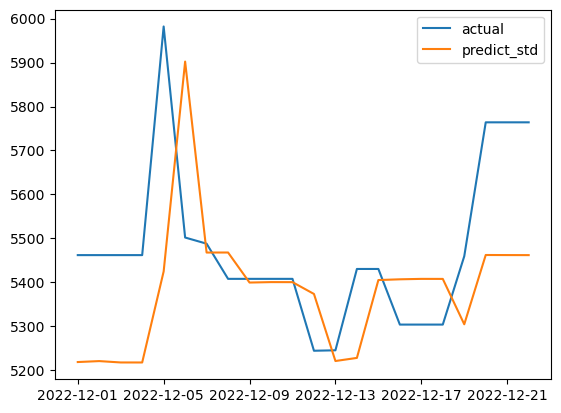

In [154]:
plt.plot(df_test_feat_yes.index, df_test_tar, label="actual")
plt.plot(df_test_feat_yes.index, rev_normal_std, label="predict_std")
plt.legend()
plt.show()

In [155]:
pred_list = []
for i in range(len(X_test_12_std)) : 
    y_pred_12_std = lasso_test6.predict(X_test_12_std[i].reshape(1,-1))
    # print("r2_score :",r2_score(y_pred_12_std, std2.transform(df_test_tar.values[i].reshape(1,-1))))
    rev_normal_std = std2.inverse_transform(y_pred_12_std.reshape(-1,1))
    print("predict price :", rev_normal_std[0])
    pred_price = rev_normal_std[0]
    pred_list.append(pred_price)
    if i == (len(X_test_12_std)-1) : 
        break
    X_test_12_std[i+1,2] = y_pred_12_std

predict price : [5218.80219805]
predict price : [5199.9402819]
predict price : [5179.69419838]
predict price : [5161.27571039]
predict price : [5151.80460337]
predict price : [5148.30493527]
predict price : [5146.69705782]
predict price : [5158.03156151]
predict price : [5172.6377334]
predict price : [5186.91593342]
predict price : [5199.78026284]
predict price : [5184.60058792]
predict price : [5166.78389212]
predict price : [5156.77290792]
predict price : [5156.75780102]
predict price : [5158.41994645]
predict price : [5160.91008461]
predict price : [5163.09492688]
predict price : [5176.76070069]
predict price : [5205.54445553]
predict price : [5231.50950871]
predict price : [5254.97583914]


In [156]:
r2_score(df_test_tar, pred_list)

-2.5793579554265387

## 12월 가격 예측 테스트 xgboost

In [83]:
X_test_12_std = std_yes_fi_price.transform(df_test_feat_yes_fi)

In [80]:
X_test_12_std.shape

(22, 4)

In [84]:
y_pred_12_std = xgb_std.predict(X_test_12_std)
rev_normal_std = std2.inverse_transform(y_pred_12_std.reshape(-1,1))
print("r2_score :",r2_score(rev_normal_std, df_test_tar.values.reshape(-1,1)))
# y_pred_12_std

r2_score : -0.6997531211380164


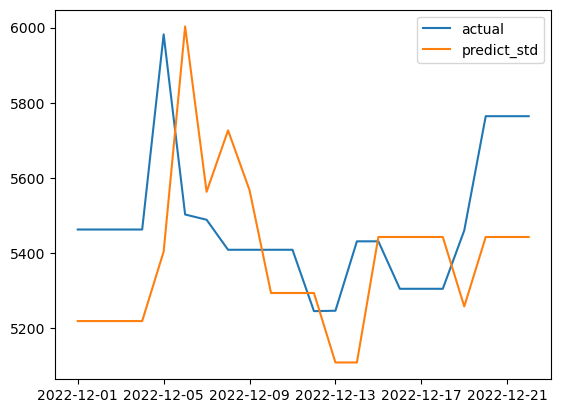

In [75]:
plt.plot(df_test_feat_yes.index, df_test_tar, label="actual")
plt.plot(df_test_feat_yes.index, rev_normal_std, label="predict_std")
plt.legend()
plt.show()

In [82]:
# X_test_12_std[0]
y_pred_12_std = xgb_std.predict(X_test_12_std[0].reshape(1,-1))
rev_normal_std = std2.inverse_transform(y_pred_12_std.reshape(-1,1))
# print("r2_score :",r2_score(rev_normal_std, df_test_tar[0].reshape(-1,1)))
print(rev_normal_std)
print(df_test_tar[0].reshape(-1,1))


[[5217.9893]]
[[5462.]]


In [65]:
X_test_12_std[1,2] = y_pred_12_std[0]
X_test_12_std

array([[ 1.55763368, -0.29812356, -0.36169439],
       [ 1.55354806, -0.57971956, -0.35450771],
       [ 1.54965184, -0.18603786, -0.36169439],
       [ 1.54637793, -0.18603786, -0.36169439],
       [ 1.54007362, -0.98071814, -0.30965509],
       [ 1.52981898, -1.11317245, -0.18665309],
       [ 1.51623631, -0.43249457, -0.3001934 ],
       [ 1.49702577, -0.26569705, -0.30350499],
       [ 1.47548831, -0.25198107, -0.32242837],
       [ 1.45205686, -0.41183186, -0.32242837],
       [ 1.4419375 , -0.41183186, -0.32242837],
       [ 1.42210464, -0.17612483, -0.32242837],
       [ 1.39312648, -0.32880072, -0.36110304],
       [ 1.36964091, -0.37296568, -0.36086649],
       [ 1.345993  , -0.82219584, -0.31710617],
       [ 1.324672  , -0.82751998, -0.31710617],
       [ 1.30573202, -0.97730562, -0.31710617],
       [ 1.29812898, -0.97730562, -0.31710617],
       [ 1.28424868, -0.95595838, -0.34702877],
       [ 1.27196476, -0.51423271, -0.31024644],
       [ 1.25470232, -0.51423271, -0.310

In [66]:
y_pred_12_std = xgb_std.predict(X_test_12_std[1].reshape(1,-1))
rev_normal_std = std2.inverse_transform(y_pred_12_std.reshape(-1,1))
# print("r2_score :",r2_score(rev_normal_std, df_test_tar[0].reshape(-1,1)))
print(rev_normal_std)
print(df_test_tar[1].reshape(-1,1))

[[5272.3345]]
[[5462.]]


In [85]:
pred_list = []
for i in range(len(X_test_12_std)) : 
    y_pred_12_std = xgb_std.predict(X_test_12_std[i].reshape(1,-1))
    # print("r2_score :",r2_score(y_pred_12_std, std2.transform(df_test_tar.values[i].reshape(1,-1))))
    rev_normal_std = std2.inverse_transform(y_pred_12_std.reshape(-1,1))
    print("predict price :", rev_normal_std[0])
    pred_price = rev_normal_std[0]
    pred_list.append(pred_price)
    if i == (len(X_test_12_std)-1) : 
        break
    X_test_12_std[i+1,2] = y_pred_12_std
    


predict price : [5217.9893]
predict price : [5217.9893]
predict price : [5217.9893]
predict price : [5217.9893]
predict price : [5217.9893]
predict price : [5217.9893]
predict price : [5217.9893]
predict price : [5381.6533]
predict price : [5566.824]
predict price : [5452.1455]
predict price : [5292.803]
predict price : [5107.632]
predict price : [5002.577]
predict price : [4716.3066]
predict price : [4630.8296]
predict price : [4630.8296]
predict price : [4716.9985]
predict price : [4716.9985]
predict price : [4716.9985]
predict price : [4716.9985]
predict price : [4716.9985]
predict price : [4716.9985]


In [77]:
X_test_12_std

array([[ 1.55763368, -0.29812356, -0.36169439, -0.27542145],
       [ 1.55354806, -0.57971956, -0.36736268, -0.27542145],
       [ 1.54965184, -0.18603786, -0.36736268, -0.27542145],
       [ 1.54637793, -0.18603786, -0.36736268, -0.27542145],
       [ 1.54007362, -0.98071814, -0.36736268, -0.28102937],
       [ 1.52981898, -1.11317245, -0.36736268, -0.28872837],
       [ 1.51623631, -0.43249457, -0.36736268, -0.29367094],
       [ 1.49702577, -0.26569705, -0.36736268, -0.28578184],
       [ 1.47548831, -0.25198107, -0.32864934, -0.28834817],
       [ 1.45205686, -0.41183186, -0.28484866, -0.28834817],
       [ 1.4419375 , -0.41183186, -0.31197497, -0.28834817],
       [ 1.42210464, -0.17612483, -0.34966606, -0.32339763],
       [ 1.39312648, -0.32880072, -0.39346677, -0.33558772],
       [ 1.36964091, -0.37296568, -0.4183166 , -0.33832039],
       [ 1.345993  , -0.82219584, -0.48603147, -0.33725108],
       [ 1.324672  , -0.82751998, -0.50625026, -0.34219365],
       [ 1.30573202, -0.

In [86]:
r2_score(df_test_tar, pred_list)

-8.969067879983085

In [51]:
# for i in range(len(a)) : 
#     b = a[i,2]
#     if i == len(a)-1 : 
#         break
#     a[i+1, 2] = b

# print(a)

[[ 1  2  3]
 [ 4  5  3]
 [ 7  8  3]
 [10 11  3]]


-------------------------------------------------

In [20]:
# 데이터 스케일링
scaler = MinMaxScaler()
scaler.fit(feature)
feature = scaler.transform(feature)
scaler.fit(target)
target = scaler.transform(target)

# 데이터셋 생성
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# 데이터셋 생성
look_back = 1
trainX, trainY = create_dataset(feature, look_back)
testX, testY = create_dataset(target, look_back)

# 데이터셋 형태 변환
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# 모델 생성
model = Sequential()
model.add(LSTM(32, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

# 예측
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# 데이터 스케일링 복원
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# 모델 평가
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, np.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, np.sqrt(testScore)))

# 예측 결과 시각화
plt.figure(figsize=(12, 9))
plt.plot(testY[0], label='actual')
plt.plot(testPredict, label='prediction')
plt.legend()
plt.show()

# 예측 결과 저장
predic_df = pd.DataFrame(testPredict)

# 예측 결과 저장


ValueError: Expected 2D array, got 1D array instead:
array=[5600. 5600. 5600. ... 5664. 5592. 5242.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.